# Evaluate and plot the results of the model

## Load packages and data

In [ ]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

from pathlib import Path
from itertools import product
from pathlib import Path
project_root = (
    Path.cwd()
    .parents[0]
)
sys.path.append(str(project_root))
sys.path.append(str(f'{project_root}/run-simulation/py-files'))
from utils_calibration import calibrate_propensity_score, compute_ipw_estimate, calibration_errors
from utils_dgps import dgp_wrapper

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

In [4]:
import importlib
# Initial import
import utils_calibration
import utils_dgps

# Function to reload the module
def reload_calibration_algorithms():
    importlib.reload(utils_calibration)

# Function to reload the module
def reload_dgps():
    importlib.reload(utils_dgps)

# You can now make changes to calibration_algorithms.py and reload it
reload_calibration_algorithms()
reload_dgps()

In [ ]:
# Treatment Effect:
n_obs = 10000000
overlap = 0
R2_d = 0
share_treated = 0
dim_x = 3
overlap = 0.5

dgp_dict = {
    'n_obs':n_obs,
    'overlap': overlap}


dgp_type = 'sim_v06_drug' # sim_v06_nonlinear
data_dict = dgp_wrapper(dgp_type=dgp_type, **dgp_dict)

ate = data_dict['treatment_effect']
print(f'True Treatment Effect, Setting 1 Simulation Drug: {ate}')

True Treatment Effect, Setting 1 Simulation Drug: -0.9972829999999999


In [ ]:
df=pd.read_pickle('results/results_drug.pkl')
df=pd.DataFrame(df)
df.head()
window_size = 1.5
theta = -1
dim_x = 3

In [7]:
df['R2_d'] = 0  
df['share_treated'] = 0  
df['dim_x'] = dim_x

## Basic Overview

In [9]:
grouping_columns = ["n_obs", "R2_d", "dim_x", "learner_g", "learner_m", "method", "calib_method", "clipping_threshold", "overlap", "share_treated"]
df.groupby(grouping_columns).mean()

coefs  \
n_obs R2_d dim_x learner_g learner_m method             calib_method clipping_threshold overlap share_treated             
200   0    3     LGBM      LGBM      alg-1-uncalibrated uncalibrated 1.000000e-12       0.1     0             -1.728711   
                                                                                        0.5     0             -1.082933   
                                                                                        0.9     0             -1.002893   
                                                                     1.000000e-02       0.1     0             -1.328286   
                                                                                        0.5     0             -1.034201   
...                                                                                                                 ...   
4000  0    3     RF        RF        oracle             uncalibrated 1.000000e-02       0.5     0             -0.999470   
                                                                                        0.9     0             -1.008288   
                                                                     1.000000e-01       0.1     0             -1.002528   
                                                                                        0.5     0             -1.000156   
                                                                                        0.9     0             -1.008265   

                                                                                                                    ses  \
n_obs R2_d dim_x learner_g learner_m method             calib_method clipping_threshold overlap share_treated             
200   0    3     LGBM      LGBM      alg-1-uncalibrated uncalibrated 1.000000e-12       0.1     0              1.979420   
                                                                                        0.5     0              0.921178   
                                                                                        0.9     0              0.541535   
                                                                     1.000000e-02       0.1     0              1.317510   
                                                                                        0.5     0              0.866238   
...                                                                                                                 ...   
4000  0    3     RF        RF        oracle             uncalibrated 1.000000e-02       0.5     0              0.082023   
                                                                                        0.9     0              0.071930   
                                                                     1.000000e-01       0.1     0              0.087078   
                                                                                        0.5     0              0.080480   
                                                                                        0.9     0              0.071923   

                                                                                                               cover  \
n_obs R2_d dim_x learner_g learner_m method             calib_method clipping_threshold overlap share_treated          
200   0    3     LGBM      LGBM      alg-1-uncalibrated uncalibrated 1.000000e-12       0.1     0               1.00   
                                                                                        0.5     0               0.99   
                                                                                        0.9     0               0.96   
                                                                     1.000000e-02       0.1     0               1.00   
                                                                                        0.5     0               0.99   
...                                                                       

## Unique Values

In [10]:
df= df.sort_values(by=["n_obs","dim_x","clipping_threshold"])
for col in grouping_columns:
    print(f"{col}: {df[col].unique()}")

n_obs: [200 500 1000 2000 4000]
R2_d: [0]
dim_x: [3]
learner_g: ['Linear' 'RF' 'LGBM']
learner_m: ['Logit' 'RF' 'LGBM']
method: ['alg-1-uncalibrated' 'alg-2-nested-cross-fitting-calib'
 'alg-3-cross-fitted-calib' 'alg-4-single-split-calib'
 'alg-5-full-sample-calib' 'oracle']
calib_method: ['uncalibrated' 'isotonic' 'platt' 'ivap']
clipping_threshold: [1.e-12 1.e-02 1.e-01]
overlap: [0.1 0.5 0.9]
share_treated: [0]


In [11]:
df_results = pd.DataFrame(columns=[
    'n_obs', 'R2_d', 'dim_x', 'learner_g', 'learner_m', 'method','calib_method', 
    'clipping_threshold', 'rmses', 'K', 'ece_u', 'ece_q', 'ece_u_5', 'ece_q_5', 
    'ece_l2','mce','procedure', 'estimate', 'overlap', 'share_treated'
])

In [12]:
df= df.rename(columns={"coefs": "IRM"})
df= df.rename(columns={"ipw_coefs": "IPW"})
df= df.rename(columns={"plr_coefs": "PLR"})
df= df.rename(columns={"t_coefs": "T"})

#df['calib_method'] = df['calib_method'].str.replace('ivap','IVAP')
#df['calib_method'] = df['calib_method'].str.replace('oracle','Oracle')
#df['calib_method'] = df['calib_method'].str.replace('uncalibrated','Uncalib')
#df['calib_method'] = df['calib_method'].str.replace('platt','Platt')
#df['calib_method'] = df['calib_method'].str.replace('isotonic','Isotonic')

# filter DataFrame

for calib_method in enumerate(["uncalibrated", "isotonic", "ivap", "oracle", "platt"]):
    df_new = df[df["calib_method"].isin(calib_method)]

    # melt DataFrame for plotting
    grouping_columns = ["n_obs", "dim_x", "R2_d", "learner_g", "learner_m", "method", "calib_method", "clipping_threshold", 
                        "rmses", "K","ece_u","ece_q","ece_u_5","ece_q_5","ece_l2","mce", "overlap", "share_treated"]
    df_new = df_new.melt(
        id_vars=grouping_columns,
        value_vars=["IRM", "IPW", "PLR"],
        var_name="procedure",
        value_name="estimate")

    df_results = pd.concat([df_results, df_new], ignore_index=True)

In [ ]:
method_mapping = {
    "alg-1-uncalibrated": "Alg-1-uncalib",
    "alg-2-nested-cross-fitting-calib": "Alg-2-nested-cf",
    "alg-3-cross-fitted-calib": "Alg-3-cf",
    "alg-4-single-split-calib": "Alg-4-single-split",
    "alg-5-full-sample-calib": "Alg-5-full-sample",
    "oracle": "Oracle"
}
df_results["method"] = df_results["method"].replace(method_mapping)
calib_mapping = {
    "uncalibrated": "Uncalib",
    "isotonic": "Iso",
    "platt": "Platt",
    "ivap": "IVAP"}
df_results["calib_method"] = df_results["calib_method"].replace(calib_mapping)
df_results.insert(1, "Method", df_results[['method','calib_method']].agg('-'.join, axis=1))

In [ ]:
# fixed values
overlap = 0.5
share_treated = 0
R2_d = 0

dgp_type = 'sim_v06_drug'
n_obs = 2000
clipping_threshold = 0.1
learner_g = "LGBM"
learner_m = "LGBM"

n_obs_list = [500, 1000, 2000]
overlap_list = [0.1, 0.5, 0.9]
R2_d_list = [0]



clipping_thresholds = [1e-12, 0.01, 0.1]
learner_dict_g = {'Linear','LGBM','RF'}
learner_dict_m = {'Logit','LGBM', 'RF'}


# Filter calibration method
df= df_results.copy()
calib_methods=["Uncalib", "Iso"]#, "ivap", "oracle", "platt"]
df = df[df["calib_method"].isin(calib_methods)]

Method_mapping = {
    "Oracle-Uncalib": "Oracle",
    "Alg-1-uncalib-Uncalib": "Alg-1-Uncalib"}
df.loc[:, "Method"] = df["Method"].replace(Method_mapping)

df= df.sort_values(by=["procedure","Method"])

## Distribution of Estimates

### Variation with respect to learner of propensity score

In [12]:
# Create the directory if it doesn't exist
directory = 'results/figures_drug/learner_m/'
os.makedirs(directory, exist_ok=True)
sns.set_theme(style="whitegrid", context="paper")
colors = sns.color_palette("colorblind",6)

for (i_n_obs, n_obs) in enumerate(n_obs_list):
    for (i_clipping_threshold, clipping_threshold) in enumerate(clipping_thresholds):
        df_filtered = df[
            (df["n_obs"] == n_obs) &
            (df["dim_x"] == dim_x) &
            (df["learner_g"] == learner_g) &
            (df["clipping_threshold"] == clipping_threshold) & 
            (df["overlap"] == overlap) &
            (df["R2_d"] == R2_d) &
            (df["share_treated"] == share_treated)
        ]

        col = "learner_m"

        g = sns.displot(
            data=df_filtered,
            x="estimate",
            hue="Method",
            row="procedure",
            col=col,
            kind="kde",
            height=3,
            aspect=1.5, 
            palette=colors)

        for ax in g.axes.flat:
            ax.axvline(x=theta, color='r', linestyle=':')
            ax.set_xlim(theta - window_size, theta + window_size)
            
        filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
        f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')

        plt.savefig(f'{directory}{filename}',bbox_inches='tight')
        plt.clf()
        plt.close()

### Variation with respect to outcome regression

In [28]:
# Create the directory if it doesn't exist
directory = 'results/figures_drug/learner_g/'
os.makedirs(directory, exist_ok=True)
sns.set_theme(style="whitegrid", context="paper")
colors = sns.color_palette("colorblind",6)

for (i_n_obs, n_obs) in enumerate(n_obs_list):
    for (i_clipping_threshold, clipping_threshold) in enumerate(clipping_thresholds):
        df_filtered = df[
            (df["n_obs"] == n_obs) &
            (df["dim_x"] == dim_x) &
            (df["learner_m"] == learner_m) &
            (df["clipping_threshold"] == clipping_threshold) & 
            (df["overlap"] == overlap) &
            (df["R2_d"] == R2_d) &
            (df["share_treated"] == share_treated)
        ]

        col = "learner_g"

        g = sns.displot(
            data=df_filtered,
            x="estimate",
            hue="Method",
            row="procedure",
            col=col,
            kind="kde",
            height=3,
            aspect=1.5, 
            palette=colors)

        for ax in g.axes.flat:
            ax.axvline(x=theta, color='r', linestyle=':')
            ax.set_xlim(theta - window_size, theta + window_size)
            
        filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
        f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')

        plt.savefig(f'{directory}{filename}',bbox_inches='tight')
        plt.clf()
        plt.close()

### Distribution of estimates with respect to observation size

In [ ]:
# Create the directory if it doesn't exist
directory = 'results/figures_drug/n_obs/'
os.makedirs(directory, exist_ok=True)

sns.set_theme(style="whitegrid", context="paper")
colors = sns.color_palette("colorblind",6)

for (i_clipping_threshold, clipping_threshold) in enumerate(clipping_thresholds):
    df_filtered = df[
            (df["dim_x"] == dim_x) &
            (df["learner_g"] == learner_g) & 
            (df["learner_m"] == learner_m) &
            (df["clipping_threshold"] == clipping_threshold)&
            (df["overlap"] == overlap) &
            (df["R2_d"] == R2_d) &
            (df["share_treated"] == share_treated)
        ]
    df_filtered = df_filtered[df_filtered["n_obs"].isin(n_obs_list)]
    col = "n_obs"

    g = sns.displot(
            data=df_filtered,
            x="estimate",
            hue="Method",
            row="procedure",
            col=col,
            kind="kde",
            height=3,
            aspect=1.5)

    for ax in g.axes.flat:
            ax.axvline(x=theta, color='r', linestyle=':')
            ax.set_xlim(theta - window_size, theta + window_size)

    filename = (f'n_obs_{0:05d}_dim_x_{dim_x:03d}_learner_m_{learner_m}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
    f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')
            
    plt.savefig(f'{directory}{filename}',bbox_inches='tight')
    plt.clf()
    plt.close()

### Distribution with respect to clipping threshold

In [27]:
# Create the directory if it doesn't exist
directory = 'results/figures_drug/clipping_threshold/'
os.makedirs(directory, exist_ok=True)

sns.set_theme(style="whitegrid", context="paper")
colors = sns.color_palette("colorblind",6)

for (i_n_obs, n_obs) in enumerate(n_obs_list):

    df_filtered = df[
        (df["n_obs"] == n_obs) &
        (df["dim_x"] == dim_x) &
        (df["learner_g"] == learner_g) & 
        (df["learner_m"] == learner_m) &
        (df["overlap"] == overlap) &
        (df["R2_d"] == R2_d) &
        (df["share_treated"] == share_treated)
    ]

    col = "clipping_threshold"

    g = sns.displot(
        data=df_filtered,
        x="estimate",
        hue="Method",
        row="procedure",
        col=col,
        kind="kde",
        height=3,
        aspect=1.5)

    for ax in g.axes.flat:
        ax.axvline(x=theta, color='r', linestyle=':')
        ax.set_xlim(theta - window_size, theta + window_size)
        
    filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{learner_m}_learner_g_{learner_g}_clip_{0:.2f}_'
    f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')
            
    plt.savefig(f'{directory}{filename}',bbox_inches='tight')
    plt.clf()
    plt.close()

### Distribution with respect to overlap

In [29]:
# Create the directory if it doesn't exist
directory = 'results/figures_drug/overlap/'
os.makedirs(directory, exist_ok=True)

sns.set_theme(style="whitegrid", context="paper")
colors = sns.color_palette("colorblind",6)

for (i_clipping_threshold, clipping_threshold) in enumerate(clipping_thresholds):
    for (i_n_obs, n_obs) in enumerate(n_obs_list):

        df_filtered = df[
            (df["n_obs"] == n_obs) &
            (df["dim_x"] == dim_x) &
            (df["learner_g"] == learner_g) & 
            (df["learner_m"] == learner_m) &
            (df["clipping_threshold"] == clipping_threshold)
        ]

        col = "overlap"

        g = sns.displot(
            data=df_filtered,
            x="estimate",
            hue="Method",
            row="procedure",
            col=col,
            kind="kde",
            height=3,
            aspect=1.5)

        for ax in g.axes.flat:
            ax.axvline(x=theta, color='r', linestyle=':')
            ax.set_xlim(theta - window_size, theta + window_size)

        filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{learner_m}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
        f'R2d_{R2_d:.2f}_overlap_{0:.2f}_share_treated_{share_treated:.2f}.pdf')   

        plt.savefig(f'{directory}{filename}',bbox_inches='tight')
        plt.clf()
        plt.close()

## Graphs: Treatment and Calibration Errors by Sample Size and Dimension

In [21]:
df = df_results.copy()
df["bias"]= df["estimate"]-theta
Method_mapping = {
    "Oracle-Uncalib": "Oracle",
    "Alg-1-uncalib-Uncalib": "Alg-1-Uncalib"}
df["Method"] = df["Method"].replace(Method_mapping)

In [31]:
# Common groupby columns
groupby_cols = ['n_obs', 'dim_x', 'R2_d', 'learner_g', 
                'learner_m', 'clipping_threshold', 
                'procedure', 'Method', 'overlap', 
                'share_treated']

# Columns to calculate the mean from
mean_cols = ['ece_q', 'ece_q_5', 'ece_u', 'ece_u_5', 'ece_l2', 'mce']

# Group by and calculate means for specified columns
mean_results = df.groupby(groupby_cols)[mean_cols].mean().reset_index()

# Prepare the calibration errors DataFrame
calib_errors = mean_results.rename(columns={"ece_q": "ECE Quantile (b=10)"})
calib_errors['ECE Quantile (b=5)'] = mean_results['ece_q_5']
calib_errors['ECE Uniform (b=10)'] = mean_results['ece_u']
calib_errors['ECE Uniform (b=5)'] = mean_results['ece_u_5']
calib_errors['L2-CE Uniform (b=10)'] = mean_results['ece_l2']
calib_errors['MCE Uniform (b=10)'] = mean_results['mce']

# Replace clipping_threshold values for readability
calib_errors['clipping_threshold'] = calib_errors['clipping_threshold'].replace({
    1.e-12: 'Unclipped', 
    1.e-2: 'Clipped_0.01', 
    1.e-1: 'Clipped_0.1'
})
calib_errors['Method_Clip']= calib_errors[['Method','clipping_threshold']].agg('-'.join, axis=1)

#### Plot Calibration Errors

In [32]:
calib_errors = calib_errors.sort_values(["Method_Clip","n_obs","R2_d","overlap","share_treated","dim_x","learner_g","learner_m"])

In [33]:
df_filtered = calib_errors[
            (calib_errors["learner_m"] == learner_m) & 
            (calib_errors["dim_x"] == dim_x) & 
            (calib_errors["R2_d"] == R2_d) & 
            (calib_errors["overlap"] == overlap) & 
            (calib_errors["share_treated"] == share_treated)
            ]

In [34]:
# Create the directory if it doesn't exist
directory = 'results/figures_drug/calib_errors/'
os.makedirs(directory, exist_ok=True)

pal = ['#018571', "#252525","#091e75", "#662506", "#850157", "#390025"]
sns.set_theme(style="whitegrid", context="paper")


# fixed values
learner_g = "LGBM"
clipping = 0.1
dim_x=3
R2_d_list = [0]
R2_d = 0
share_treated = 0
overlap = 0.5

overlap_list = [0.1, 0.5, 0.9]
n_obs_list = [200,500,1000,2000,4000]
clipping_thresholds = [0.01, 0.1]
learner_dict_m = {'Logit','LGBM','RF'}

for (i_clipping_threshold, clipping_threshold) in enumerate(clipping_thresholds):
    for (i_learner_m, learner_m) in enumerate(learner_dict_m):

        df_filtered = calib_errors[
        (calib_errors["learner_m"] == learner_m) & 
        (calib_errors["dim_x"] == dim_x) & 
        (calib_errors["R2_d"] == R2_d) & 
        (calib_errors["overlap"] == overlap) & 
        (calib_errors["share_treated"] == share_treated)
        ]

        methods= [f'Alg-1-Uncalib-Clipped_{clipping_threshold}','Alg-1-Uncalib-Unclipped','Alg-2-nested-cf-Iso-Unclipped','Alg-3-cf-Iso-Unclipped',
                    'Alg-4-single-split-Iso-Unclipped','Alg-5-full-sample-Iso-Unclipped']

        df_filtered = df_filtered[df_filtered["n_obs"].isin(n_obs_list)]
        df_filtered = df_filtered[df_filtered["Method_Clip"].isin(methods)]

        fig, ([g1,g2],[g3,g4],[g5,g6]) = plt.subplots(3, 2, figsize=(10, 10), sharex=True)

        l1= sns.lineplot(data = df_filtered, ax=g1,
                        x = "n_obs",hue="Method_Clip", y = 'ECE Uniform (b=5)', 
                        errorbar = None, style="Method_Clip",
                        dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                        palette=sns.color_palette(pal, 6),
                        legend=None)

        l2= sns.lineplot(data = df_filtered, ax=g2,
                        x = "n_obs",hue="Method_Clip", y = 'ECE Uniform (b=10)', 
                        errorbar = None, style="Method_Clip",
                        dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                        palette=sns.color_palette(pal, 6),
                        legend=None)

        l3= sns.lineplot(data = df_filtered, ax=g3,
                        x = "n_obs",hue="Method_Clip", y = 'ECE Quantile (b=5)', 
                        errorbar = None, style="Method_Clip",
                        dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                        palette=sns.color_palette(pal, 6),
                        legend=None)

        l4= sns.lineplot(data = df_filtered, ax=g4,
                        x = "n_obs",hue="Method_Clip", y = 'ECE Quantile (b=10)', 
                        errorbar = None, style="Method_Clip",
                        dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                        palette=sns.color_palette(pal, 6),
                        legend=None)

        l5= sns.lineplot(data = df_filtered, ax=g5,
                        x = "n_obs",hue="Method_Clip", y = 'L2-CE Uniform (b=10)', 
                        errorbar = None, style="Method_Clip",
                        dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                        palette=sns.color_palette(pal, 6),
                        legend=None)

        l6= sns.lineplot(data = df_filtered, ax=g6,
                        x = "n_obs",hue="Method_Clip", y = 'MCE Uniform (b=10)', 
                        errorbar = None, style="Method_Clip",
                        dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                        palette=sns.color_palette(pal, 6),
                        legend=None)

        labels=[f'Alg-1-Clipped','Alg-1-Uncalib','Alg-2-nested-cf-Iso','Alg-3-cf-Iso','Alg-4-single-split-Iso','Alg-5-full-sample-Iso']

        l5.set_xlabel('sample size')
        l6.set_xlabel('sample size')
        fig.legend(labels=labels, ncol=1, prop={'size': 12}, loc='center right', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(1, 0.54))
        #fig.legend(labels=labels,ncol=1,prop={'size': 12}, loc='upper right', bbox_to_anchor=(0.42, 0.305, 0.485, 0.58),facecolor='white',framealpha=1,frameon = 1)

        filename = (f'n_obs_{0:05d}_dim_x_{dim_x:03d}_learner_m_{learner_m}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
        f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
        plt.savefig(f'{directory}{filename}',bbox_inches='tight')
        plt.clf()
        plt.close()

### Plot treatment effect metrics

In [22]:
def evaluate_estimation(ate: np.ndarray, level: float=0.95) -> dict: #ate_var: float, n_obs: int,n_obs:float
    ate_true= float(theta)
    bias = ate - ate_true
    #ate_var=quantile_normal = scipy.stats.norm.ppf((1+level)/2)
    np.nanvar(ate)
    return {
        'Mean Bias': np.nanmean(bias),
        #'RMSE': np.nanstd(bias),
        'RMSE': np.sqrt(((ate - np.full(len(ate), ate_true)) ** 2).mean()),
        'MAE': np.nanmean(np.abs(bias)),
        'Std. dev.': np.nanstd(ate),
    }

In [23]:
df_eval = df.groupby(['n_obs','dim_x','R2_d','learner_g','learner_m','clipping_threshold','procedure' ,'Method', 'overlap','share_treated']
                     ).estimate.apply(evaluate_estimation).reset_index()
df_eval= df_eval.rename(columns={"level_10": "Metrics"})

In [24]:
n_obs_list = [200,500,1000,2000,4000]
dim_x_list = [3]
share_treated = 0
R2_d_list = [0]


overlap_list = [0.1, 0.5, 0.9]
clipping_thresholds = [1e-12, 0.01, 0.1]
learner_dict_g = ['Linear', 'LGBM', 'RF']
learner_dict_m = ['Logit', 'LGBM', 'RF']
procedure_list = ['IPW', 'IRM', 'PLR']

results = pd.DataFrame(columns=['MAE', 'Mean Bias', 'RMSE', 'Std. dev.', 'n_obs', 'dim_x', 
                                'R2_d', 'procedure', 'Method'])#, 'overlap', 'share_treated'])


for n_obs, clipping_threshold, learner_g, learner_m, procedure, dim_x, overlap in product(
    n_obs_list, clipping_thresholds, learner_dict_g, learner_dict_m, procedure_list, dim_x_list, overlap_list):
    
    # Filter data based on current parameter combination
    df_eval_new = df_eval[
        (df_eval['n_obs'] == n_obs) &
        (df_eval['clipping_threshold'] == clipping_threshold) &
        (df_eval['learner_m'] == learner_m) &
        (df_eval['procedure'] == procedure) &
        (df_eval['dim_x'] == dim_x) &
        (df_eval['R2_d'] == R2_d) &
        (df_eval['learner_g'] == learner_g) &
        (df_eval["overlap"] == overlap) & 
        (df_eval["share_treated"] == share_treated)
    ]

    # Pivot and format the new DataFrame
    df_eval_new = df_eval_new.pivot_table('estimate', ['Method'], 'Metrics').iloc[:, 0:4]
    df_eval_new = df_eval_new.assign(n_obs=n_obs, learner_g=learner_g, learner_m=learner_m,
                                     procedure=procedure, dim_x=dim_x, R2_d=R2_d,
                                     clipping_threshold=clipping_threshold, overlap=overlap,
                                     share_treated=share_treated, Method=df_eval_new.index)

    # Append to results
    results = pd.concat([results, df_eval_new], ignore_index=True)

# Replace clipping thresholds
results['clipping_threshold'] = results['clipping_threshold'].replace(
    {1.e-12: 'Unclipped', 0.01: 'Clipped_0.01', 0.1: 'Clipped_0.1'})

# Add 'Method_Clip' column
results.insert(1, "Method_Clip", results[['Method', 'clipping_threshold']].agg('-'.join, axis=1))
# For correct matches in legend
results = results.sort_values(["Method_Clip","n_obs","R2_d","overlap","share_treated","dim_x","learner_g","learner_m"])

In [31]:
def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Ensure fontweight is set to bold by default
    text_kwargs.setdefault("fontweight", "bold")

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

In [26]:
procedures_list = [['IPW', 'IRM'],
                   ['IRM', 'PLR']]

pal = ['#018571', "#252525","#091e75", "#662506", "#850157", "#5c5c5c"]
sns.set_theme(style="whitegrid", context="paper")

share_treated = 0
R2_d_list = [0]
overlap = 0.5
clipping_thresholds = [0.01, 0.1]
learner_g = "LGBM"
n_obs_list = [200, 500, 1000, 2000, 4000]

In [ ]:
# Plot with respect to sample size

for (_, clipping_threshold) in enumerate(clipping_thresholds):
    for (_, learner_m) in enumerate(learner_dict_m):
        for _, procedures in enumerate(procedures_list):
            directory = f'results/figures_drug/ate_errors_alg_2_{procedures[0]}_{procedures[1]}/'
            os.makedirs(directory, exist_ok=True)
            df_filtered = results[
                (results["learner_g"] == learner_g) & 
                (results["learner_m"] == learner_m) &
                (results["R2_d"] == R2_d) & 
                (results["dim_x"] == dim_x)&
                (results["overlap"] == overlap) & 
                (results["share_treated"] == share_treated)
            ].copy()

            methods= [f'Alg-1-Uncalib-Clipped_{clipping_threshold}', 'Alg-1-Uncalib-Unclipped', f'Alg-2-nested-cf-Iso-Clipped_{clipping_threshold}', 
                      'Alg-2-nested-cf-Iso-Unclipped',f'Alg-2-nested-cf-IVAP-Clipped_{clipping_threshold}', 'Alg-2-nested-cf-Platt-Unclipped'] #

            df_filtered = df_filtered[df_filtered["n_obs"].isin(n_obs_list)]
            df_filtered = df_filtered[df_filtered["Method_Clip"].isin(methods)]            
            
            df_filtered1 = df_filtered[df_filtered["procedure"].isin([procedures[0]])].copy()
            df_filtered2 = df_filtered[df_filtered["procedure"].isin([procedures[1]])].copy()

            fig, ([g1,g2],[g3,g4],[g5,g6]) = plt.subplots(3, 2, figsize=(10, 10), sharex=True)
            rows_plot = ['RMSE', 'MAE', 'Std. dev.']

            l1= sns.lineplot(data = df_filtered1, ax=g1,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l3= sns.lineplot(data = df_filtered1, ax=g3,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l5= sns.lineplot(data = df_filtered1, ax=g5,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l2= sns.lineplot(data = df_filtered2, ax=g2,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l4= sns.lineplot(data = df_filtered2, ax=g4,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l6= sns.lineplot(data = df_filtered2, ax=g6,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)


            labels=[f'Alg-1-Clipped', 'Alg-1-Uncalib', f'Alg-2-cf-Iso-Clipped','Alg-2-cf-Iso',
                     'Alg-2-cf-IVAP', 'Alg-2-cf-Platt']          
            l5.set_xlabel('sample size')
            l6.set_xlabel('sample size')

            fig.legend(labels=labels,ncol=1, prop={'size': 12}, loc='center right', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(1, 0.54)) #labels=labels,
            add_headers(fig, row_headers = None, col_headers=[f'Model = {procedures[0]}',f'Model = {procedures[1]}'])

            filename = (f'n_obs_{0:05d}_dim_x_{dim_x:03d}_learner_m_{learner_m}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
            f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
            plt.savefig(f'{directory}{filename}',bbox_inches='tight')
            plt.clf()
            plt.close()

In [70]:
# Plot with respect to sample 

pal = ['#018571', "#252525","#091e75", "#662506", "#850157", "#5c5c5c"]
sns.set_theme(style="whitegrid", context="paper")

for (i_clipping_threshold, clipping_threshold) in enumerate(clipping_thresholds):
    for (i_learner_m, learner_m) in enumerate(learner_dict_m):
        for _, procedures in enumerate(procedures_list):
            directory = f'results/figures_drug/ate_errors_alg_3_{procedures[0]}_{procedures[1]}/'
            os.makedirs(directory, exist_ok=True)

            df_filtered = results[
                (results["learner_g"] == learner_g) & 
                (results["learner_m"] == learner_m) &
                (results["R2_d"] == R2_d) & 
                (results["dim_x"] == dim_x)&
                (results["overlap"] == overlap) & 
                (results["share_treated"] == share_treated)
            ].copy()

            methods= [f'Alg-1-Uncalib-Clipped_{clipping_threshold}', 'Alg-1-Uncalib-Unclipped', f'Alg-3-cf-Iso-Clipped_{clipping_threshold}',
                        'Alg-3-cf-Iso-Unclipped', 'Alg-3-cf-IVAP-Unclipped', 'Alg-3-cf-Platt-Unclipped']

            df_filtered = df_filtered[df_filtered["n_obs"].isin(n_obs_list)]
            df_filtered = df_filtered[df_filtered["Method_Clip"].isin(methods)]            
            
            df_filtered1 = df_filtered[df_filtered["procedure"].isin([procedures[0]])]
            df_filtered2 = df_filtered[df_filtered["procedure"].isin([procedures[1]])]

            fig, ([g1,g2],[g3,g4],[g5,g6]) = plt.subplots(3, 2, figsize=(10, 10), sharex=True)
            rows_plot = ['RMSE', 'MAE', 'Std. dev.']

            l1= sns.lineplot(data = df_filtered1, ax=g1,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l3= sns.lineplot(data = df_filtered1, ax=g3,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l5= sns.lineplot(data = df_filtered1, ax=g5,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l2= sns.lineplot(data = df_filtered2, ax=g2,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l4= sns.lineplot(data = df_filtered2, ax=g4,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l6= sns.lineplot(data = df_filtered2, ax=g6,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)


            labels=[f'Alg-1-Clipped', 'Alg-1-Uncalib', f'Alg-3-cf-Iso-Clipped',
                    'Alg-3-cf-Iso', 'Alg-3-cf-IVAP', 'Alg-3-cf-Platt']            
            l5.set_xlabel('sample size')
            l6.set_xlabel('sample size')

            fig.legend(labels=labels,ncol=1, prop={'size': 12}, loc='center right', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(1, 0.54)) #labels=labels,
            add_headers(fig, row_headers = None, col_headers=[f'Model = {procedures[0]}',f'Model = {procedures[1]}'])

            filename = (f'n_obs_{0:05d}_dim_x_{dim_x:03d}_learner_m_{learner_m}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
            f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
            plt.savefig(f'{directory}{filename}',bbox_inches='tight')
            plt.clf()
            plt.close()

In [74]:
# Plot with respect to sample 

pal = ['#018571', "#252525","#091e75", "#662506", "#850157", "#5c5c5c"]
sns.set_theme(style="whitegrid", context="paper")

for (i_clipping_threshold, clipping_threshold) in enumerate(clipping_thresholds):
    for (i_learner_m, learner_m) in enumerate(learner_dict_m):
        for _, procedures in enumerate(procedures_list):
            directory = f'results/figures_drug/ate_errors_alg_4_{procedures[0]}_{procedures[1]}/'
            os.makedirs(directory, exist_ok=True)

            df_filtered = results[
                (results["learner_g"] == learner_g) & 
                (results["learner_m"] == learner_m) &
                (results["R2_d"] == R2_d) & 
                (results["dim_x"] == dim_x)&
                (results["overlap"] == overlap) & 
                (results["share_treated"] == share_treated)
            ].copy()

            methods= [f'Alg-1-Uncalib-Clipped_{clipping_threshold}', 'Alg-1-Uncalib-Unclipped', f'Alg-4-single-split-Iso-Clipped_{clipping_threshold}',
                        'Alg-4-single-split-Iso-Unclipped', f'Alg-4-single-split-IVAP-Clipped_{clipping_threshold}', 'Alg-4-single-split-Platt-Unclipped']

            df_filtered = df_filtered[df_filtered["n_obs"].isin(n_obs_list)]
            df_filtered = df_filtered[df_filtered["Method_Clip"].isin(methods)]            
            
            df_filtered1 = df_filtered[df_filtered["procedure"].isin([procedures[0]])].copy()
            df_filtered2 = df_filtered[df_filtered["procedure"].isin([procedures[1]])].copy()

            fig, ([g1,g2],[g3,g4],[g5,g6]) = plt.subplots(3, 2, figsize=(10, 10), sharex=True)
            rows_plot = ['RMSE', 'MAE', 'Std. dev.']

            l1= sns.lineplot(data = df_filtered1, ax=g1,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l3= sns.lineplot(data = df_filtered1, ax=g3,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l5= sns.lineplot(data = df_filtered1, ax=g5,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l2= sns.lineplot(data = df_filtered2, ax=g2,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l4= sns.lineplot(data = df_filtered2, ax=g4,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l6= sns.lineplot(data = df_filtered2, ax=g6,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)


            labels=[f'Alg-1-Clipped', 'Alg-1-Uncalib', f'Alg-4-single-split-Iso-Clipped',
                    'Alg-4-single-split-Iso', 'Alg-4-single-split-IVAP-Clipped', 'Alg-4-single-split-Platt']            
            l5.set_xlabel('sample size')
            l6.set_xlabel('sample size')

            fig.legend(labels=labels,ncol=1, prop={'size': 12}, loc='center right', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(1, 0.54)) #labels=labels,
            add_headers(fig, row_headers = None, col_headers=[f'Model = {procedures[0]}',f'Model = {procedures[1]}'])

            filename = (f'n_obs_{0:05d}_dim_x_{dim_x:03d}_learner_m_{learner_m}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
            f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
            plt.savefig(f'{directory}{filename}',bbox_inches='tight')
            plt.clf()
            plt.close()

In [75]:
# Plot with respect to sample size

pal = ['#018571', "#252525","#091e75", "#662506", "#850157", "#5c5c5c"]
sns.set_theme(style="whitegrid", context="paper")

for (i_clipping_threshold, clipping_threshold) in enumerate(clipping_thresholds):
    for (i_learner_m, learner_m) in enumerate(learner_dict_m):
        for _, procedures in enumerate(procedures_list):
   
            directory = f'results/figures_drug/ate_errors_{procedures[0]}_{procedures[1]}/'
            os.makedirs(directory, exist_ok=True)

            df_filtered = results[
                    (results["learner_g"] == learner_g) & 
                    (results["learner_m"] == learner_m) &
                    (results["R2_d"] == R2_d) & 
                    (results["dim_x"] == dim_x) &
                    (results["overlap"] == overlap) & 
                    (results["share_treated"] == share_treated)].copy()


            methods= [f'Alg-1-Uncalib-Clipped_{clipping_threshold}','Alg-1-Uncalib-Unclipped',f'Alg-2-nested-cf-Iso-Clipped_{clipping_threshold}','Alg-3-cf-Iso-Unclipped',
                      f'Alg-4-single-split-Iso-Clipped_{clipping_threshold}','Alg-5-full-sample-Iso-Unclipped']

            df_filtered = df_filtered[df_filtered["n_obs"].isin(n_obs_list)]
            df_filtered = df_filtered[df_filtered["Method_Clip"].isin(methods)]            

            df_filtered1 = df_filtered[df_filtered["procedure"].isin([procedures[0]])]
            df_filtered2 = df_filtered[df_filtered["procedure"].isin([procedures[1]])]

            fig, ([g1,g2],[g3,g4],[g5,g6]) = plt.subplots(3, 2, figsize=(10, 10), sharex=True)
            rows_plot = ['RMSE', 'MAE', 'Std. dev.']

            l1= sns.lineplot(data = df_filtered1, ax=g1,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l3= sns.lineplot(data = df_filtered1, ax=g3,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l5= sns.lineplot(data = df_filtered1, ax=g5,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l2= sns.lineplot(data = df_filtered2, ax=g2,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l4= sns.lineplot(data = df_filtered2, ax=g4,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l6= sns.lineplot(data = df_filtered2, ax=g6,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)


            labels=['Alg-1-Clipped',f'Alg-1-Uncalib','Alg-2-nested-cf-Iso-Clipped','Alg-3-cf-Iso','Alg-4-single-split-Iso-Clipped',
                    'Alg-5-full-sample-Iso']            
            l5.set_xlabel('sample size')
            l6.set_xlabel('sample size')

            fig.legend(labels=labels, ncol=1, prop={'size': 12}, loc='center right', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(1, 0.54))
            add_headers(fig, row_headers = None, col_headers=[f'Model = {procedures[0]}',f'Model = {procedures[1]}'])

            filename = (f'n_obs_{0:05d}_dim_x_{dim_x:03d}_learner_m_{learner_m}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
            f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
            plt.savefig(f'{directory}{filename}',bbox_inches='tight')
            plt.clf()
            plt.close()

In [32]:
# Plot with respect to sample size
procedures = ['IPW', 'IRM', 'PLR']

pal = ['#018571', "#252525","#091e75", "#662506", "#850157", "#5c5c5c"]
sns.set_theme(style="whitegrid", context="paper")

for (i_clipping_threshold, clipping_threshold) in enumerate(clipping_thresholds):
    for (i_learner_m, learner_m) in enumerate(learner_dict_m):
   
            directory = f'results/figures_drug/ate_errors_alg_2_{procedures[0]}_{procedures[1]}_{procedures[2]}/'
            os.makedirs(directory, exist_ok=True)

            df_filtered = results[
                    (results["learner_g"] == learner_g) & 
                    (results["learner_m"] == learner_m) &
                    (results["R2_d"] == R2_d) & 
                    (results["dim_x"] == dim_x) &
                    (results["overlap"] == overlap) & 
                    (results["share_treated"] == share_treated)].copy()


            methods= [f'Alg-1-Uncalib-Clipped_{clipping_threshold}', 'Alg-1-Uncalib-Unclipped', f'Alg-2-nested-cf-Iso-Clipped_{clipping_threshold}',
                        'Alg-2-nested-cf-Iso-Unclipped', f'Alg-2-nested-cf-IVAP-Clipped_{clipping_threshold}', 'Alg-2-nested-cf-Platt-Unclipped']

            df_filtered = df_filtered[df_filtered["n_obs"].isin(n_obs_list)]
            df_filtered = df_filtered[df_filtered["Method_Clip"].isin(methods)]            

            df_filtered1 = df_filtered[df_filtered["procedure"].isin([procedures[0]])]
            df_filtered2 = df_filtered[df_filtered["procedure"].isin([procedures[1]])]
            df_filtered3 = df_filtered[df_filtered["procedure"].isin([procedures[2]])]


            fig, ([g1,g2,g3],[g4,g5,g6],[g7,g8,g9]) = plt.subplots(3, 3, figsize=(12, 10), sharex=True)
            rows_plot = ['RMSE', 'MAE', 'Std. dev.']
            plt.subplots_adjust(wspace=0.3)

            l1= sns.lineplot(data = df_filtered1, ax=g1,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l4= sns.lineplot(data = df_filtered1, ax=g4,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l7= sns.lineplot(data = df_filtered1, ax=g7,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l2= sns.lineplot(data = df_filtered2, ax=g2,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l5= sns.lineplot(data = df_filtered2, ax=g5,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l8= sns.lineplot(data = df_filtered2, ax=g8,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)
            
            l3= sns.lineplot(data = df_filtered3, ax=g3,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)
            l6= sns.lineplot(data = df_filtered3, ax=g6,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)
            
            l9= sns.lineplot(data = df_filtered3, ax=g9,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            labels=[f'Alg-1-Clipped', 'Alg-1-Uncalib', f'Alg-2-nested-cf-Iso-Clipped',
                    'Alg-2-nested-cf-Iso', 'Alg-2-nested-cf-IVAP-Clipped', 'Alg-2-nested-cf-Platt']    
            l7.set_xlabel('sample size')
            l8.set_xlabel('sample size')
            l9.set_xlabel('sample size')
            
            #fig.legend(labels=labels,ncol=1, prop={'size': 12}, loc='center right', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(1, 0.565)) #labels=labels,
            fig.legend(labels=labels, ncol=3, prop={'size': 12}, loc='lower center', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(0.5, 0))
            add_headers(fig, row_headers = None, col_headers=[f'Model = {procedures[0]}', f'Model = {procedures[1]}', f'Model = {procedures[2]}'])

            filename = (f'n_obs_{0:05d}_dim_x_{dim_x:03d}_learner_m_{learner_m}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
            f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
            plt.savefig(f'{directory}{filename}',bbox_inches='tight')
            plt.clf()
            plt.close()
            #plt.show()

In [34]:
# Plot with respect to sample size
procedures = ['IPW', 'IRM', 'PLR']

pal = ['#018571', "#252525","#091e75", "#662506", "#850157", "#5c5c5c"]
sns.set_theme(style="whitegrid", context="paper")

for (i_clipping_threshold, clipping_threshold) in enumerate(clipping_thresholds):
    for (i_learner_m, learner_m) in enumerate(learner_dict_m):
   
            directory = f'results/figures_drug/ate_errors_alg_3_{procedures[0]}_{procedures[1]}_{procedures[2]}/'
            os.makedirs(directory, exist_ok=True)

            df_filtered = results[
                    (results["learner_g"] == learner_g) & 
                    (results["learner_m"] == learner_m) &
                    (results["R2_d"] == R2_d) & 
                    (results["dim_x"] == dim_x) &
                    (results["overlap"] == overlap) & 
                    (results["share_treated"] == share_treated)].copy()


            methods= [f'Alg-1-Uncalib-Clipped_{clipping_threshold}', 'Alg-1-Uncalib-Unclipped', f'Alg-3-cf-Iso-Clipped_{clipping_threshold}',
                        'Alg-3-cf-Iso-Unclipped', f'Alg-3-cf-IVAP-Clipped_{clipping_threshold}', 'Alg-3-cf-Platt-Unclipped']

            df_filtered = df_filtered[df_filtered["n_obs"].isin(n_obs_list)]
            df_filtered = df_filtered[df_filtered["Method_Clip"].isin(methods)]            

            df_filtered1 = df_filtered[df_filtered["procedure"].isin([procedures[0]])]
            df_filtered2 = df_filtered[df_filtered["procedure"].isin([procedures[1]])]
            df_filtered3 = df_filtered[df_filtered["procedure"].isin([procedures[2]])]


            fig, ([g1,g2,g3],[g4,g5,g6],[g7,g8,g9]) = plt.subplots(3, 3, figsize=(12, 10), sharex=True)
            rows_plot = ['RMSE', 'MAE', 'Std. dev.']
            plt.subplots_adjust(wspace=0.3)

            l1= sns.lineplot(data = df_filtered1, ax=g1,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l4= sns.lineplot(data = df_filtered1, ax=g4,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l7= sns.lineplot(data = df_filtered1, ax=g7,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l2= sns.lineplot(data = df_filtered2, ax=g2,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l5= sns.lineplot(data = df_filtered2, ax=g5,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l8= sns.lineplot(data = df_filtered2, ax=g8,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)
            
            l3= sns.lineplot(data = df_filtered3, ax=g3,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)
            l6= sns.lineplot(data = df_filtered3, ax=g6,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)
            
            l9= sns.lineplot(data = df_filtered3, ax=g9,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            labels=[f'Alg-1-Clipped', 'Alg-1-Uncalib', f'Alg-3-cf-Iso-Clipped',
                    'Alg-3-cf-Iso', 'Alg-3-cf-IVAP-Clipped', 'Alg-3-cf-Platt']    
            l7.set_xlabel('sample size')
            l8.set_xlabel('sample size')
            l9.set_xlabel('sample size')
            
            #fig.legend(labels=labels,ncol=1, prop={'size': 12}, loc='center right', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(1, 0.565)) #labels=labels,
            fig.legend(labels=labels, ncol=3, prop={'size': 12}, loc='lower center', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(0.5, 0))
            add_headers(fig, row_headers = None, col_headers=[f'Model = {procedures[0]}', f'Model = {procedures[1]}', f'Model = {procedures[2]}'])

            filename = (f'n_obs_{0:05d}_dim_x_{dim_x:03d}_learner_m_{learner_m}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
            f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
            plt.savefig(f'{directory}{filename}',bbox_inches='tight')
            plt.clf()
            plt.close()
            #plt.show()

In [35]:
# Plot with respect to sample size
procedures = ['IPW', 'IRM', 'PLR']

pal = ['#018571', "#252525","#091e75", "#662506", "#850157", "#5c5c5c"]
sns.set_theme(style="whitegrid", context="paper")

for (i_clipping_threshold, clipping_threshold) in enumerate(clipping_thresholds):
    for (i_learner_m, learner_m) in enumerate(learner_dict_m):
   
            directory = f'results/figures_drug/ate_errors_alg_4_{procedures[0]}_{procedures[1]}_{procedures[2]}/'
            os.makedirs(directory, exist_ok=True)

            df_filtered = results[
                    (results["learner_g"] == learner_g) & 
                    (results["learner_m"] == learner_m) &
                    (results["R2_d"] == R2_d) & 
                    (results["dim_x"] == dim_x) &
                    (results["overlap"] == overlap) & 
                    (results["share_treated"] == share_treated)].copy()


            methods= [f'Alg-1-Uncalib-Clipped_{clipping_threshold}', 'Alg-1-Uncalib-Unclipped', f'Alg-4-single-split-Iso-Clipped_{clipping_threshold}',
                        'Alg-4-single-split-Iso-Unclipped', f'Alg-4-single-split-IVAP-Clipped_{clipping_threshold}', 'Alg-4-single-split-Platt-Unclipped']

            df_filtered = df_filtered[df_filtered["n_obs"].isin(n_obs_list)]
            df_filtered = df_filtered[df_filtered["Method_Clip"].isin(methods)]            

            df_filtered1 = df_filtered[df_filtered["procedure"].isin([procedures[0]])]
            df_filtered2 = df_filtered[df_filtered["procedure"].isin([procedures[1]])]
            df_filtered3 = df_filtered[df_filtered["procedure"].isin([procedures[2]])]


            fig, ([g1,g2,g3],[g4,g5,g6],[g7,g8,g9]) = plt.subplots(3, 3, figsize=(12, 10), sharex=True)
            rows_plot = ['RMSE', 'MAE', 'Std. dev.']
            plt.subplots_adjust(wspace=0.3)

            l1= sns.lineplot(data = df_filtered1, ax=g1,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l4= sns.lineplot(data = df_filtered1, ax=g4,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l7= sns.lineplot(data = df_filtered1, ax=g7,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l2= sns.lineplot(data = df_filtered2, ax=g2,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l5= sns.lineplot(data = df_filtered2, ax=g5,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l8= sns.lineplot(data = df_filtered2, ax=g8,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)
            
            l3= sns.lineplot(data = df_filtered3, ax=g3,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)
            l6= sns.lineplot(data = df_filtered3, ax=g6,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)
            
            l9= sns.lineplot(data = df_filtered3, ax=g9,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            labels=[f'Alg-1-Clipped', 'Alg-1-Uncalib', f'Alg-4-single-split-Iso-Clipped',
                    'Alg-4-single-split-Iso', 'Alg-4-single-split-IVAP-Clipped', 'Alg-4-single-split-Platt']    
            l7.set_xlabel('sample size')
            l8.set_xlabel('sample size')
            l9.set_xlabel('sample size')
            
            #fig.legend(labels=labels,ncol=1, prop={'size': 12}, loc='center right', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(1, 0.565)) #labels=labels,
            fig.legend(labels=labels, ncol=3, prop={'size': 12}, loc='lower center', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(0.5, 0))
            add_headers(fig, row_headers = None, col_headers=[f'Model = {procedures[0]}', f'Model = {procedures[1]}', f'Model = {procedures[2]}'])

            filename = (f'n_obs_{0:05d}_dim_x_{dim_x:03d}_learner_m_{learner_m}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
            f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
            plt.savefig(f'{directory}{filename}',bbox_inches='tight')
            plt.clf()
            plt.close()
            #plt.show()

In [36]:
# Plot with respect to sample size
procedures = ['IPW', 'IRM', 'PLR']

pal = ['#018571', "#252525","#091e75", "#662506", "#850157", "#5c5c5c"]
sns.set_theme(style="whitegrid", context="paper")

for (i_clipping_threshold, clipping_threshold) in enumerate(clipping_thresholds):
    for (i_learner_m, learner_m) in enumerate(learner_dict_m):
   
            directory = f'results/figures_drug/ate_errors_{procedures[0]}_{procedures[1]}_{procedures[2]}/'
            os.makedirs(directory, exist_ok=True)

            df_filtered = results[
                    (results["learner_g"] == learner_g) & 
                    (results["learner_m"] == learner_m) &
                    (results["R2_d"] == R2_d) & 
                    (results["dim_x"] == dim_x) &
                    (results["overlap"] == overlap) & 
                    (results["share_treated"] == share_treated)].copy()


            methods= [f'Alg-1-Uncalib-Clipped_{clipping_threshold}','Alg-1-Uncalib-Unclipped',f'Alg-2-nested-cf-Iso-Clipped_{clipping_threshold}','Alg-3-cf-Iso-Unclipped',
                      f'Alg-4-single-split-Iso-Clipped_{clipping_threshold}','Alg-5-full-sample-Iso-Unclipped']

            df_filtered = df_filtered[df_filtered["n_obs"].isin(n_obs_list)]
            df_filtered = df_filtered[df_filtered["Method_Clip"].isin(methods)]            

            df_filtered1 = df_filtered[df_filtered["procedure"].isin([procedures[0]])]
            df_filtered2 = df_filtered[df_filtered["procedure"].isin([procedures[1]])]
            df_filtered3 = df_filtered[df_filtered["procedure"].isin([procedures[2]])]


            fig, ([g1,g2,g3],[g4,g5,g6],[g7,g8,g9]) = plt.subplots(3, 3, figsize=(12, 10), sharex=True)
            rows_plot = ['RMSE', 'MAE', 'Std. dev.']
            plt.subplots_adjust(wspace=0.3)

            l1= sns.lineplot(data = df_filtered1, ax=g1,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l4= sns.lineplot(data = df_filtered1, ax=g4,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l7= sns.lineplot(data = df_filtered1, ax=g7,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l2= sns.lineplot(data = df_filtered2, ax=g2,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l5= sns.lineplot(data = df_filtered2, ax=g5,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            l8= sns.lineplot(data = df_filtered2, ax=g8,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)
            
            l3= sns.lineplot(data = df_filtered3, ax=g3,
                            x = "n_obs",hue="Method_Clip", y = 'RMSE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)
            l6= sns.lineplot(data = df_filtered3, ax=g6,
                            x = "n_obs",hue="Method_Clip", y = 'MAE', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)
            
            l9= sns.lineplot(data = df_filtered3, ax=g9,
                            x = "n_obs",hue="Method_Clip", y = 'Std. dev.', 
                            errorbar = None, style="Method_Clip",
                            dashes=True, markers=['X','o','d','^','<','>'], markersize=8,
                            palette=sns.color_palette(pal, 6),
                            legend=None)

            labels=['Alg-1-Clipped',f'Alg-1-Uncalib','Alg-2-nested-cf-Iso-Clipped','Alg-3-cf-Iso','Alg-4-single-split-Iso-Clipped',
                    'Alg-5-full-sample-Iso']            
            l7.set_xlabel('sample size')
            l8.set_xlabel('sample size')
            l9.set_xlabel('sample size')
            
            #fig.legend(labels=labels,ncol=1, prop={'size': 12}, loc='center right', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(1, 0.565)) #labels=labels,
            fig.legend(labels=labels, ncol=3, prop={'size': 12}, loc='lower center', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(0.5, 0))
            add_headers(fig, row_headers = None, col_headers=[f'Model = {procedures[0]}', f'Model = {procedures[1]}', f'Model = {procedures[2]}'])

            filename = (f'n_obs_{0:05d}_dim_x_{dim_x:03d}_learner_m_{learner_m}_learner_g_{learner_g}_clip_{clipping_threshold:.2f}_'
            f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
            plt.savefig(f'{directory}{filename}',bbox_inches='tight')
            plt.clf()
            plt.close()
            #plt.show()

## Calibrated Propensity scores

In [ ]:
# Data preparation
theta = -1
n_obs = 2000
dim_x = 3
overlap = 0.1
R2_d = 0
share_treated = 0

dgp_type="sim_v06_drug"

dgp_dict = {
    'n_obs':n_obs,
    'overlap':overlap}

data_dict = dgp_wrapper(dgp_type=dgp_type, **dgp_dict)

treatment = data_dict['treatment']
outcome = data_dict['outcome']
m_0 = data_dict['propensity_score']
x = data_dict['covariates']

In [ ]:
# Fit models
log_model = LogisticRegression()
lgbm_model = LGBMClassifier(verbose=-1)
rf_model = RandomForestClassifier()
m_hat_log = cross_val_predict(log_model, x, treatment, cv=5, method="predict_proba")[:, 1]
m_hat_lgbm = cross_val_predict(lgbm_model, x, treatment, cv=5, method="predict_proba")[:, 1]
m_hat_rf = cross_val_predict(rf_model, x, treatment, cv=5, method="predict_proba")[:, 1]

In [ ]:
calib_methods = [
    ('alg-1-uncalibrated', 'uncalibrated'),
    ('alg-2-nested-cross-fitting-calib', 'isotonic'),
    ('alg-2-nested-cross-fitting-calib', 'platt'),
    ('alg-2-nested-cross-fitting-calib', 'ivap'),
    ('alg-3-cross-fitted-calib', 'isotonic'),
    ('alg-3-cross-fitted-calib', 'platt'),
    ('alg-3-cross-fitted-calib', 'ivap'),
    ('alg-4-single-split-calib', 'isotonic'),
    ('alg-4-single-split-calib', 'platt'),
    ('alg-4-single-split-calib', 'ivap'),
    ('alg-5-full-sample-calib', 'isotonic'),
    ('oracle', 'uncalibrated'),
]

In [ ]:
propensity_score_dict = {
    # 'm_0': m_0,
    'm_hat_log': m_hat_log,
    'm_hat_lgbm': m_hat_lgbm,
    'm_hat_rf': m_hat_rf
}
clipping_thresholds = [1e-12, 0.1]

df_propensities = pd.DataFrame({
    'treatment': treatment,
    'outcome': outcome,
    'm_0': m_0,
    'm_hat_log': m_hat_log,
    'm_hat_lgbm': m_hat_lgbm,    
    'm_hat_rf': m_hat_rf,
    'x_2':x["x2"]})

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smpls = list(kf.split(X=np.zeros(len(treatment)), y=treatment))
df_ps_calibrated=pd.DataFrame()

for m_hat_name, m_hat in propensity_score_dict.items():
    print(f"Calibrating {m_hat_name}")
    for clipping_threshold in clipping_thresholds:        
        for i_calib_method, (method, calib_method) in enumerate(calib_methods):
            method = method
            calib_method = calib_method
            # calibration inclues clipping

            m_hat_calib = calibrate_propensity_score(
                propensity_score=m_hat,
                treatment=treatment,
                calib_method=calib_method,
                method = method,
                clipping_threshold=clipping_threshold,
                covariates=x,
                learner_m=log_model,
                true_propensity_score=theta,
                smpls = smpls
                )
            
            #df_propensities[f'{m_hat_name}_{calib_method}_{clip}'] = m_hat_calib
            df_propensities["calib_method"]=calib_method
            df_propensities["method"]=method
            df_propensities["clipping_threshold"]=clipping_threshold
            df_propensities["m_hat_name"]=m_hat_name
            df_propensities["ps"]=m_hat_calib
            
            df_ps_calibrated = pd.concat([df_ps_calibrated, df_propensities], ignore_index=True)


Calibrating m_hat_log
Calibrating m_hat_lgbm
Calibrating m_hat_rf


In [ ]:
# Replace clipping thresholds
df_ps_calibrated['clipping_threshold'] = df_ps_calibrated['clipping_threshold'].replace(
    {1.e-12: '', 0.1: '-Clipped'})

method_mapping = {
    "alg-1-uncalibrated": "Alg-1-uncalib",
    "alg-2-nested-cross-fitting-calib": "Alg-2-nested-cf",
    "alg-3-cross-fitted-calib": "Alg-3-cf",
    "alg-4-single-split-calib": "Alg-4-single-split",
    "alg-5-full-sample-calib": "Alg-5-full-sample",
    "oracle": "Oracle"
}
df_ps_calibrated["method"] = df_ps_calibrated["method"].replace(method_mapping)

calib_mapping = {
    "uncalibrated": "Uncalib",
    "isotonic": "Iso",
    "platt": "Platt",
    "ivap": "IVAP"}
df_ps_calibrated["calib_method"] = df_ps_calibrated["calib_method"].replace(calib_mapping)

df_ps_calibrated.insert(1, "Method", df_ps_calibrated[['method','calib_method']].agg('-'.join, axis=1))

Method_mapping = {
    "Oracle-Uncalib": "Oracle",
    "Alg-1-uncalib-Uncalib": "Alg-1-Uncalib"}
df_ps_calibrated["Method"] = df_ps_calibrated["Method"].replace(Method_mapping)
# Add 'Method_Clip' column
df_ps_calibrated.insert(1, "Method_Clip", df_ps_calibrated[['Method', 'clipping_threshold']].agg(''.join, axis=1))

In [ ]:
df_ps_calibrated['m_hat_name'] = df_ps_calibrated['m_hat_name'].str.replace('m_hat_log','Logistic')
df_ps_calibrated['m_hat_name'] = df_ps_calibrated['m_hat_name'].str.replace('m_hat_lgbm','LGBM') 
df_ps_calibrated['m_hat_name'] = df_ps_calibrated['m_hat_name'].str.replace('m_hat_rf','RF')
df_ps_calibrated= df_ps_calibrated.rename(columns={"m_hat_name": "Learner"})
m_hats = ['Logistic','LGBM', 'RF']
df_ps_calibrated = df_ps_calibrated[df_ps_calibrated["Learner"].isin(m_hats)]      
Method_clip_mapping = {
    "Alg-1-Uncalib-Clipped": "Alg-1-Clipped"}
df_ps_calibrated["Method_Clip"] = df_ps_calibrated["Method_Clip"].replace(Method_clip_mapping)

#### Isotonic Regression

In [32]:
# Create the directory if it doesn't exist
directory = 'results/figures_drug/ps_calib_iso/'
os.makedirs(directory, exist_ok=True)

directory_2 = 'results/figures_drug/ps_treatment_iso/'
os.makedirs(directory_2, exist_ok=True)

methods= ['Alg-1-Uncalib','Alg-2-nested-cf-Iso','Alg-3-cf-Iso',
          'Alg-4-single-split-Iso','Alg-5-full-sample-Iso']
df_filtered = df_ps_calibrated[df_ps_calibrated["Method_Clip"].isin(methods)]    

# facet grid
sns.set_theme(style="whitegrid", context="paper")

g = sns.FacetGrid(data=df_filtered,row='Method_Clip',col='Learner', sharex=False, sharey='row', margin_titles=True)
g.map(sns.scatterplot, "x_2", "treatment", color='#023eff',alpha=0.4)
g.map(sns.lineplot, "x_2", "ps", color='#662506')
g.map(sns.lineplot, "x_2", "m_0", color='#018571').set_axis_labels("x", "m")
g.set_titles(col_template='{col_name}', row_template='{row_name}', fontweight='bold', size=12)

# Creating custom handles for the legend
scatter_handle = plt.Line2D([], [], marker='o', color='white', markerfacecolor='#023eff', markersize=10, alpha=0.4, label='Treatment')
ps_line = plt.Line2D([], [], color='#662506', marker='', linestyle='-', label='Predicted \nPS')
true_score_line = plt.Line2D([], [], color='#018571', marker='', linestyle='-', label='True \nPS')

# Add the custom legend to the plot
g.add_legend(handles=[scatter_handle, ps_line, true_score_line], 
loc="center right",
facecolor='white',framealpha=1,frameon = 1,
)


filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
plt.savefig(f'{directory}{filename}',bbox_inches='tight')
plt.clf()
plt.close()


# Define a function to plot the histogram
def plot_histogram(data, **kwargs):
    # Separate propensity scores based on treatment assignment
    treated_propensity = data['ps'][data['treatment'] == 1]
    untreated_propensity = data['ps'][data['treatment'] == 0]
    
    # Histogram bins
    bins = np.linspace(0, 1, 50)
    
    # Create the histogram for treated
    hist_treated, bins_treated, _ = plt.hist(treated_propensity, bins=bins, 
                                              alpha=0.7, density=True, 
                                              color='#018571', edgecolor='black', 
                                              label='Treated')
    
    # Calculate histogram for untreated
    hist_untreated, bins_untreated = np.histogram(untreated_propensity, bins=bins, density=True)
    
    # Invert the untreated histogram and plot it below the zero line
    plt.bar(bins_untreated[:-1], -hist_untreated, width=np.diff(bins_untreated), 
            edgecolor='black', alpha=0.7, color='#662506', label='Untreated')
    
    # Add a horizontal line for separation
    plt.axhline(y=0, color='black', linewidth=1)
    
    # Manually set the y-axis ticks and labels to show positive values on both sides
    ticks = np.linspace(-max(hist_untreated.max(), hist_treated.max()), 
                        max(hist_untreated.max(), hist_treated.max()), 7)
    plt.yticks(ticks, [f'{abs(tick):.2f}' for tick in ticks])
    
    # Add labels and legend
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    #plt.title(f'{data["Learner"].iloc[0]}')
    plt.legend(loc='upper right')

# Use FacetGrid to create the plots
g = sns.FacetGrid(data=df_filtered, row='Method_Clip', col='Learner', sharex=False, sharey='row', margin_titles=True)
g.map_dataframe(plot_histogram)
g.set_titles(col_template='{col_name}', row_template='{row_name}', fontweight='bold', size=12)


# Optionally save each facet plot
for ax in g.axes.flatten():
    # Saving mechanism can be customized based on the title of the plot
    title = ax.title.get_text()
    #filename = f'{title.replace(" ", "_")}_ps_histogram.pdf'
    #plt.savefig(f'{directory}{filename}', bbox_inches='tight')


filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
plt.savefig(f'{directory_2}{filename}',bbox_inches='tight')
plt.clf()
plt.close()

In [ ]:
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({
    "text.usetex": True,  # Enable LaTeX rendering
    "font.family": "serif",  # Use a serif font
})

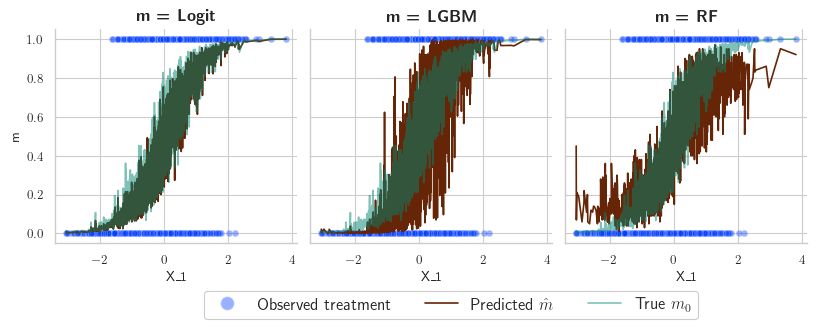

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create the directory if it doesn't exist
directory = 'results/figures_irm/ps_calib_iso_2/'
os.makedirs(directory, exist_ok=True)

methods= ['Alg-1-uncalib']
df_filtered = df_ps_calibrated[df_ps_calibrated["Method_Clip"].isin(methods)] 
df_filtered['Learner'] = df_filtered['Learner'].str.replace('Logistic','Logit')



# Define the FacetGrid
sns.set_theme(style="whitegrid", context="paper")

g = sns.FacetGrid(data=df_filtered, col='Learner', sharex=False, margin_titles=True)
g.map(sns.scatterplot, "x_1", "treatment", color='#023eff', alpha=0.4)
g.map(sns.lineplot, "x_1", "ps", color='#662506', alpha=1)  # Apply transparency here
g.map(sns.lineplot, "x_1", "m_0", color='#018571', alpha=0.5).set_axis_labels("X_1", "m")  # Apply transparency here
g.set_titles(col_template=r'\textbf{{m = {col_name}}}', fontweight='bold', size=12)

# Creating custom handles for the legend
scatter_handle = plt.Line2D([], [], marker='o', color='white', markerfacecolor='#023eff', markersize=10, alpha=0.4, label='Observed treatment')
ps_line = plt.Line2D([], [], color='#662506', marker='', linestyle='-', alpha=1, label=r'Predicted $\hat{m}$')  # Apply transparency here
true_score_line = plt.Line2D([], [], color='#018571', alpha=0.5, marker='', linestyle='-', label=r'True $m_0$')  # Apply transparency here

# Add the custom legend to the plot
g.add_legend(handles=[scatter_handle, ps_line, true_score_line], 
             ncol=3, prop={'size': 12}, loc='lower center', facecolor='white', framealpha=1, frameon=1, bbox_to_anchor=(0.35, -0.10))


filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
plt.savefig(f'{directory}{filename}',bbox_inches='tight')
plt.show()
plt.clf()

In [33]:
directory = 'results/figures_drug/ps_treatment_iso_2/'
os.makedirs(directory, exist_ok=True)

methods= ['Alg-1-Uncalib','Alg-2-nested-cf-Iso','Alg-3-cf-Iso',
          'Alg-4-single-split-Iso','Alg-5-full-sample-Iso']
df_filtered = df_ps_calibrated[df_ps_calibrated["Method_Clip"].isin(methods)]   

# Set Seaborn theme
sns.set_theme(style="whitegrid", context="paper")

def plot_overlap_ratio(data, ps_col: str, treatment_col: str, metric: str, clipping_threshold: float=1e-12, n_bins=50, **kwargs):
    valid_metrics = ['ratio', 'count']
    assert metric in valid_metrics, "Invalid metric"

    y_col = "ratio" if metric == "ratio" else "count"
    y_label = "Ratio" if metric == "ratio" else "Count"

    df_propensity = data.assign(
        m_hat=lambda d: d[ps_col].clip(clipping_threshold, 1.0 - clipping_threshold),
    )
    treatment_indicator = df_propensity[treatment_col] == 1

    bin_edges = np.linspace(df_propensity["m_hat"].min(), df_propensity["m_hat"].max(), n_bins + 1)

    bin_midpoints = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(n_bins)]
    bin_size = [(bin_edges[i + 1] - bin_edges[i]) for i in range(n_bins)]

    count_treated = [np.nan] * n_bins
    neg_count_control = [np.nan] * n_bins

    ratio_treated = [np.nan] * n_bins
    neg_ratio_control = [np.nan] * n_bins

    for i, (bin_start, bin_end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        bin_obs = (df_propensity["m_hat"] >= bin_start) & (df_propensity["m_hat"] <= bin_end) if i == 0 else (df_propensity["m_hat"] > bin_start) & (df_propensity["m_hat"] <= bin_end)

        bin_treated = bin_obs & treatment_indicator
        bin_control = bin_obs & ~treatment_indicator

        bin_n_treated = bin_treated.sum()
        bin_n_control = bin_control.sum()
        bin_n_obs = bin_n_treated + bin_n_control

        count_treated[i] = bin_n_treated
        neg_count_control[i] = -1 * bin_n_control
        ratio_treated[i] = bin_n_treated / bin_n_obs
        neg_ratio_control[i] = -1 * bin_n_control / bin_n_obs

    df_plot = pd.DataFrame({
        "bin_midpoint": bin_midpoints * 2,
        "bin_size": bin_size * 2,
        "count": count_treated + neg_count_control,
        "ratio": ratio_treated + neg_ratio_control,
        "category": ["Treated"] * n_bins + ["Control"] * n_bins,
    })

    text_kwargs = kwargs.get('text_kwargs', {}) 
    text_kwargs.setdefault("fontweight", "bold")

    # Plot using Matplotlib
    plt.bar(df_plot['bin_midpoint'][df_plot['category'] == "Treated"], df_plot[y_col][df_plot['category'] == "Treated"], 
            width=df_plot['bin_size'][df_plot['category'] == "Treated"], 
            color='#87CEEB', edgecolor='black', alpha=0.7, label='Treated')
    plt.bar(df_plot['bin_midpoint'][df_plot['category'] == "Control"], df_plot[y_col][df_plot['category'] == "Control"], 
            width=df_plot['bin_size'][df_plot['category'] == "Control"], 
            color='#FA8072', edgecolor='black', alpha=0.7, label='Untreated')
    
    plt.axhline(y=0, color='black', linewidth=1)

    # Add the dashed lines 
    plt.plot([0, 1], [0, 1], linestyle='dashed', color='black', linewidth=0.5) 
    plt.plot([0, 1], [-1, 0], linestyle='dashed', color='black', linewidth=0.5)
    
    plt.xlabel('Propensity Score', **text_kwargs)
    plt.ylabel(y_label, **text_kwargs)
    plt.title(kwargs.get('title', ''), **text_kwargs)

# Assuming df_filtered is your filtered DataFrame
g = sns.FacetGrid(data=df_filtered, row='Method_Clip', col='Learner', sharex=False, sharey='row', margin_titles=True)
g.map_dataframe(plot_overlap_ratio, ps_col='ps', treatment_col='treatment', metric='ratio')
g.set_titles(col_template='{col_name}', row_template='{row_name}', fontweight='bold', size=12)

# Add the legend below all the subplots
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, fontsize='large', bbox_to_anchor=(0.5, -0.02))

filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
plt.savefig(f'{directory}{filename}',bbox_inches='tight')
plt.clf()
plt.show()

<Figure size 900x1500 with 0 Axes>

#### IVAP

In [34]:
# Create the directory if it doesn't exist
directory = 'results/figures_drug/ps_calib_ivap/'
os.makedirs(directory, exist_ok=True)

directory_2 = 'results/figures_drug/ps_treatment_ivap/'
os.makedirs(directory_2, exist_ok=True)

methods= ['Alg-1-Uncalib','Alg-2-nested-cf-IVAP','Alg-3-cf-IVAP',
          'Alg-4-single-split-IVAP','Alg-5-full-sample-IVAP']
df_filtered = df_ps_calibrated[df_ps_calibrated["Method_Clip"].isin(methods)]    


#method_order = [f'Alg-1-Uncalib-Clipped','Alg-1-Uncalib-Unclipped','Alg-2-nested-cf-Iso-Unclipped']#,'Alg-3-cf-Iso-Unclipped']#,
                      #'Alg-4-single-split-Iso-Unclipped','Alg-5-full-sample-Iso-Unclipped']
#df_ps_calibrated['Method_Clip'] = pd.Categorical(df_ps_calibrated['Method_Clip'], categories=method_order, ordered=True)

#df_ps_calibrated['Method_Clip'] = pd.Categorical(df_ps_calibrated['Method_Clip'], categories=method_order, ordered=True)

# facet grid
g = sns.FacetGrid(data=df_filtered,row='Method_Clip',col='Learner', sharex=False, sharey='row', margin_titles=True)
g.map(sns.scatterplot, "x_2", "treatment", color='#023eff',alpha=0.4)
g.map(sns.lineplot, "x_2", "ps", color='#662506')
g.map(sns.lineplot, "x_2", "m_0", color='#018571').set_axis_labels("x", "m")
g.set_titles(col_template='{col_name}', row_template='{row_name}', fontweight='bold', size=12)

# Creating custom handles for the legend
scatter_handle = plt.Line2D([], [], marker='o', color='white', markerfacecolor='#023eff', markersize=10, alpha=0.4, label='Treatment')
ps_line = plt.Line2D([], [], color='#662506', marker='', linestyle='-', label='Predicted \nPS')
true_score_line = plt.Line2D([], [], color='#018571', marker='', linestyle='-', label='True \nPS')

# Add the custom legend to the plot
g.add_legend(handles=[scatter_handle, ps_line, true_score_line], 
loc="center right",
facecolor='white',framealpha=1,frameon = 1,
)

filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
plt.savefig(f'{directory}{filename}',bbox_inches='tight')
plt.clf()
plt.close()

# Define a function to plot the histogram
def plot_histogram(data, **kwargs):
    # Separate propensity scores based on treatment assignment
    treated_propensity = data['ps'][data['treatment'] == 1]
    untreated_propensity = data['ps'][data['treatment'] == 0]
    
    # Histogram bins
    bins = np.linspace(0, 1, 50)
    
    # Create the histogram for treated
    hist_treated, bins_treated, _ = plt.hist(treated_propensity, bins=bins, 
                                              alpha=0.7, density=True, 
                                              color='#018571', edgecolor='black', 
                                              label='Treated')
    
    # Calculate histogram for untreated
    hist_untreated, bins_untreated = np.histogram(untreated_propensity, bins=bins, density=True)
    
    # Invert the untreated histogram and plot it below the zero line
    plt.bar(bins_untreated[:-1], -hist_untreated, width=np.diff(bins_untreated), 
            edgecolor='black', alpha=0.7, color='#662506', label='Untreated')
    
    # Add a horizontal line for separation
    plt.axhline(y=0, color='black', linewidth=1)
    
    # Manually set the y-axis ticks and labels to show positive values on both sides
    ticks = np.linspace(-max(hist_untreated.max(), hist_treated.max()), 
                        max(hist_untreated.max(), hist_treated.max()), 7)
    plt.yticks(ticks, [f'{abs(tick):.2f}' for tick in ticks])
    
    # Add labels and legend
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    #plt.title(f'{data["Learner"].iloc[0]}')
    plt.legend(loc='upper right')

# Use FacetGrid to create the plots
g = sns.FacetGrid(data=df_filtered, row='Method_Clip', col='Learner', sharex=False, sharey='row', margin_titles=True)
g.map_dataframe(plot_histogram)
g.set_titles(col_template='{col_name}', row_template='{row_name}', fontweight='bold', size=12)


# Optionally save each facet plot
for ax in g.axes.flatten():
    # Saving mechanism can be customized based on the title of the plot
    title = ax.title.get_text()
    #filename = f'{title.replace(" ", "_")}_ps_histogram.pdf'
    #plt.savefig(f'{directory}{filename}', bbox_inches='tight')

filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
plt.savefig(f'{directory_2}{filename}',bbox_inches='tight')
plt.clf()
plt.close()

In [35]:
directory = 'results/figures_drug/ps_treatment_ivap_2/'
os.makedirs(directory, exist_ok=True)

methods= ['Alg-1-Uncalib','Alg-2-nested-cf-IVAP','Alg-3-cf-IVAP',
          'Alg-4-single-split-IVAP','Alg-5-full-sample-IVAP']
df_filtered = df_ps_calibrated[df_ps_calibrated["Method_Clip"].isin(methods)]   

# Set Seaborn theme
sns.set_theme(style="whitegrid", context="paper")

def plot_overlap_ratio(data, ps_col: str, treatment_col: str, metric: str, clipping_threshold: float=1e-12, n_bins=50, **kwargs):
    valid_metrics = ['ratio', 'count']
    assert metric in valid_metrics, "Invalid metric"

    y_col = "ratio" if metric == "ratio" else "count"
    y_label = "Ratio" if metric == "ratio" else "Count"

    df_propensity = data.assign(
        m_hat=lambda d: d[ps_col].clip(clipping_threshold, 1.0 - clipping_threshold),
    )
    treatment_indicator = df_propensity[treatment_col] == 1

    bin_edges = np.linspace(df_propensity["m_hat"].min(), df_propensity["m_hat"].max(), n_bins + 1)

    bin_midpoints = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(n_bins)]
    bin_size = [(bin_edges[i + 1] - bin_edges[i]) for i in range(n_bins)]

    count_treated = [np.nan] * n_bins
    neg_count_control = [np.nan] * n_bins

    ratio_treated = [np.nan] * n_bins
    neg_ratio_control = [np.nan] * n_bins

    for i, (bin_start, bin_end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        bin_obs = (df_propensity["m_hat"] >= bin_start) & (df_propensity["m_hat"] <= bin_end) if i == 0 else (df_propensity["m_hat"] > bin_start) & (df_propensity["m_hat"] <= bin_end)

        bin_treated = bin_obs & treatment_indicator
        bin_control = bin_obs & ~treatment_indicator

        bin_n_treated = bin_treated.sum()
        bin_n_control = bin_control.sum()
        bin_n_obs = bin_n_treated + bin_n_control

        count_treated[i] = bin_n_treated
        neg_count_control[i] = -1 * bin_n_control
        ratio_treated[i] = bin_n_treated / bin_n_obs
        neg_ratio_control[i] = -1 * bin_n_control / bin_n_obs

    df_plot = pd.DataFrame({
        "bin_midpoint": bin_midpoints * 2,
        "bin_size": bin_size * 2,
        "count": count_treated + neg_count_control,
        "ratio": ratio_treated + neg_ratio_control,
        "category": ["Treated"] * n_bins + ["Control"] * n_bins,
    })

    text_kwargs = kwargs.get('text_kwargs', {}) 
    text_kwargs.setdefault("fontweight", "bold")

    # Plot using Matplotlib
    plt.bar(df_plot['bin_midpoint'][df_plot['category'] == "Treated"], df_plot[y_col][df_plot['category'] == "Treated"], 
            width=df_plot['bin_size'][df_plot['category'] == "Treated"], 
            color='#87CEEB', edgecolor='black', alpha=0.7, label='Treated')
    plt.bar(df_plot['bin_midpoint'][df_plot['category'] == "Control"], df_plot[y_col][df_plot['category'] == "Control"], 
            width=df_plot['bin_size'][df_plot['category'] == "Control"], 
            color='#FA8072', edgecolor='black', alpha=0.7, label='Untreated')
    
    plt.axhline(y=0, color='black', linewidth=1)

    # Add the dashed lines 
    plt.plot([0, 1], [0, 1], linestyle='dashed', color='black', linewidth=0.5) 
    plt.plot([0, 1], [-1, 0], linestyle='dashed', color='black', linewidth=0.5)
    
    plt.xlabel('Propensity Score', **text_kwargs)
    plt.ylabel(y_label, **text_kwargs)
    plt.title(kwargs.get('title', ''), **text_kwargs)

# Assuming df_filtered is your filtered DataFrame
g = sns.FacetGrid(data=df_filtered, row='Method_Clip', col='Learner', sharex=False, sharey='row', margin_titles=True)
g.map_dataframe(plot_overlap_ratio, ps_col='ps', treatment_col='treatment', metric='ratio')
g.set_titles(col_template='{col_name}', row_template='{row_name}', fontweight='bold', size=12)

# Add the legend below all the subplots
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, fontsize='large', bbox_to_anchor=(0.5, -0.02))

filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
plt.savefig(f'{directory}{filename}',bbox_inches='tight')
plt.clf()
plt.show()

<Figure size 900x1200 with 0 Axes>

#### Platt

In [36]:
# Create the directory if it doesn't exist
directory = 'results/figures_drug/ps_calib_platt/'
os.makedirs(directory, exist_ok=True)

directory_2 = 'results/figures_drug/ps_treatment_platt/'
os.makedirs(directory_2, exist_ok=True)

methods= ['Alg-1-Uncalib','Alg-2-nested-cf-Platt','Alg-3-cf-Platt',
          'Alg-4-single-split-Platt','Alg-5-full-sample-Platt']
df_filtered = df_ps_calibrated[df_ps_calibrated["Method_Clip"].isin(methods)]    


#method_order = [f'Alg-1-Uncalib-Clipped','Alg-1-Uncalib-Unclipped','Alg-2-nested-cf-Iso-Unclipped']#,'Alg-3-cf-Iso-Unclipped']#,
                      #'Alg-4-single-split-Iso-Unclipped','Alg-5-full-sample-Iso-Unclipped']
#df_ps_calibrated['Method_Clip'] = pd.Categorical(df_ps_calibrated['Method_Clip'], categories=method_order, ordered=True)

#df_ps_calibrated['Method_Clip'] = pd.Categorical(df_ps_calibrated['Method_Clip'], categories=method_order, ordered=True)

# facet grid
g = sns.FacetGrid(data=df_filtered,row='Method_Clip',col='Learner', sharex=False, sharey='row', margin_titles=True)
g.map(sns.scatterplot, "x_2", "treatment", color='#023eff',alpha=0.4)
g.map(sns.lineplot, "x_2", "ps", color='#662506')
g.map(sns.lineplot, "x_2", "m_0", color='#018571').set_axis_labels("x", "m")
g.set_titles(col_template='{col_name}', row_template='{row_name}', fontweight='bold', size=12)

# Creating custom handles for the legend
scatter_handle = plt.Line2D([], [], marker='o', color='white', markerfacecolor='#023eff', markersize=10, alpha=0.4, label='Treatment')
ps_line = plt.Line2D([], [], color='#662506', marker='', linestyle='-', label='Predicted \nPS')
true_score_line = plt.Line2D([], [], color='#018571', marker='', linestyle='-', label='True \nPS')

# Add the custom legend to the plot
g.add_legend(handles=[scatter_handle, ps_line, true_score_line], 
loc="center right",
facecolor='white',framealpha=1,frameon = 1,
)

filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
plt.savefig(f'{directory}{filename}',bbox_inches='tight')
plt.clf()
plt.close()

# Define a function to plot the histogram
def plot_histogram(data, **kwargs):
    # Separate propensity scores based on treatment assignment
    treated_propensity = data['ps'][data['treatment'] == 1]
    untreated_propensity = data['ps'][data['treatment'] == 0]
    
    # Histogram bins
    bins = np.linspace(0, 1, 50)
    
    # Create the histogram for treated
    hist_treated, bins_treated, _ = plt.hist(treated_propensity, bins=bins, 
                                              alpha=0.7, density=True, 
                                              color='#018571', edgecolor='black', 
                                              label='Treated')
    
    # Calculate histogram for untreated
    hist_untreated, bins_untreated = np.histogram(untreated_propensity, bins=bins, density=True)
    
    # Invert the untreated histogram and plot it below the zero line
    plt.bar(bins_untreated[:-1], -hist_untreated, width=np.diff(bins_untreated), 
            edgecolor='black', alpha=0.7, color='#662506', label='Untreated')
    
    # Add a horizontal line for separation
    plt.axhline(y=0, color='black', linewidth=1)
    
    # Manually set the y-axis ticks and labels to show positive values on both sides
    ticks = np.linspace(-max(hist_untreated.max(), hist_treated.max()), 
                        max(hist_untreated.max(), hist_treated.max()), 7)
    plt.yticks(ticks, [f'{abs(tick):.2f}' for tick in ticks])
    
    # Add labels and legend
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    #plt.title(f'{data["Learner"].iloc[0]}')
    plt.legend(loc='upper right')

# Use FacetGrid to create the plots
g = sns.FacetGrid(data=df_filtered, row='Method_Clip', col='Learner', sharex=False, sharey='row', margin_titles=True)
g.map_dataframe(plot_histogram)
g.set_titles(col_template='{col_name}', row_template='{row_name}', fontweight='bold', size=12)


# Optionally save each facet plot
for ax in g.axes.flatten():
    # Saving mechanism can be customized based on the title of the plot
    title = ax.title.get_text()
    #filename = f'{title.replace(" ", "_")}_ps_histogram.pdf'
    #plt.savefig(f'{directory}{filename}', bbox_inches='tight')

filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
plt.savefig(f'{directory_2}{filename}',bbox_inches='tight')
plt.clf()
plt.close()

In [37]:
directory = 'results/figures_drug/ps_treatment_platt_2/'
os.makedirs(directory, exist_ok=True)

methods= ['Alg-1-Uncalib','Alg-2-nested-cf-Platt','Alg-3-cf-Platt',
          'Alg-4-single-split-Platt','Alg-5-full-sample-Platt']
df_filtered = df_ps_calibrated[df_ps_calibrated["Method_Clip"].isin(methods)]     

# Set Seaborn theme
sns.set_theme(style="whitegrid", context="paper")

def plot_overlap_ratio(data, ps_col: str, treatment_col: str, metric: str, clipping_threshold: float=1e-12, n_bins=20, **kwargs):
    valid_metrics = ['ratio', 'count']
    assert metric in valid_metrics, "Invalid metric"

    y_col = "ratio" if metric == "ratio" else "count"
    y_label = "Ratio" if metric == "ratio" else "Count"

    df_propensity = data.assign(
        m_hat=lambda d: d[ps_col].clip(clipping_threshold, 1.0 - clipping_threshold),
    )
    treatment_indicator = df_propensity[treatment_col] == 1

    bin_edges = np.linspace(df_propensity["m_hat"].min(), df_propensity["m_hat"].max(), n_bins + 1)

    bin_midpoints = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(n_bins)]
    bin_size = [(bin_edges[i + 1] - bin_edges[i]) for i in range(n_bins)]

    count_treated = [np.nan] * n_bins
    neg_count_control = [np.nan] * n_bins

    ratio_treated = [np.nan] * n_bins
    neg_ratio_control = [np.nan] * n_bins

    for i, (bin_start, bin_end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        bin_obs = (df_propensity["m_hat"] >= bin_start) & (df_propensity["m_hat"] <= bin_end) if i == 0 else (df_propensity["m_hat"] > bin_start) & (df_propensity["m_hat"] <= bin_end)

        bin_treated = bin_obs & treatment_indicator
        bin_control = bin_obs & ~treatment_indicator

        bin_n_treated = bin_treated.sum()
        bin_n_control = bin_control.sum()
        bin_n_obs = bin_n_treated + bin_n_control

        count_treated[i] = bin_n_treated
        neg_count_control[i] = -1 * bin_n_control
        ratio_treated[i] = bin_n_treated / bin_n_obs
        neg_ratio_control[i] = -1 * bin_n_control / bin_n_obs

    df_plot = pd.DataFrame({
        "bin_midpoint": bin_midpoints * 2,
        "bin_size": bin_size * 2,
        "count": count_treated + neg_count_control,
        "ratio": ratio_treated + neg_ratio_control,
        "category": ["Treated"] * n_bins + ["Control"] * n_bins,
    })

    text_kwargs = kwargs.get('text_kwargs', {}) 
    text_kwargs.setdefault("fontweight", "bold")

    # Plot using Matplotlib
    plt.bar(df_plot['bin_midpoint'][df_plot['category'] == "Treated"], df_plot[y_col][df_plot['category'] == "Treated"], 
            width=df_plot['bin_size'][df_plot['category'] == "Treated"], 
            color='#87CEEB', edgecolor='black', alpha=0.7, label='Treated')
    plt.bar(df_plot['bin_midpoint'][df_plot['category'] == "Control"], df_plot[y_col][df_plot['category'] == "Control"], 
            width=df_plot['bin_size'][df_plot['category'] == "Control"], 
            color='#FA8072', edgecolor='black', alpha=0.7, label='Untreated')
    
    plt.axhline(y=0, color='black', linewidth=1)

    # Add the dashed lines 
    plt.plot([0, 1], [0, 1], linestyle='dashed', color='black', linewidth=0.5) 
    plt.plot([0, 1], [-1, 0], linestyle='dashed', color='black', linewidth=0.5)
    
    plt.xlabel('Propensity Score', **text_kwargs)
    plt.ylabel(y_label, **text_kwargs)
    plt.title(kwargs.get('title', ''), **text_kwargs)

# Assuming df_filtered is your filtered DataFrame
g = sns.FacetGrid(data=df_filtered, row='Method_Clip', col='Learner', sharex=False, sharey='row', margin_titles=True)
g.map_dataframe(plot_overlap_ratio, ps_col='ps', treatment_col='treatment', metric='ratio')
g.set_titles(col_template='{col_name}', row_template='{row_name}', fontweight='bold', size=12)

# Add the legend below all the subplots
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, fontsize='large', bbox_to_anchor=(0.5, -0.02))

filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
plt.savefig(f'{directory}{filename}',bbox_inches='tight')
plt.clf()
plt.show()

<Figure size 900x1200 with 0 Axes>

### Plot Propensity Scores by Treatment

In [38]:
# IRM
n_obs = 2000
overlap = 0.1

dgp_type="sim_v06_drug"

dgp_dict = {
    'n_obs':n_obs,
    'overlap':overlap}

data_dict = dgp_wrapper(dgp_type=dgp_type, **dgp_dict)

treatment = data_dict['treatment']
outcome = data_dict['outcome']
m_0 = data_dict['propensity_score']
x = data_dict['covariates']

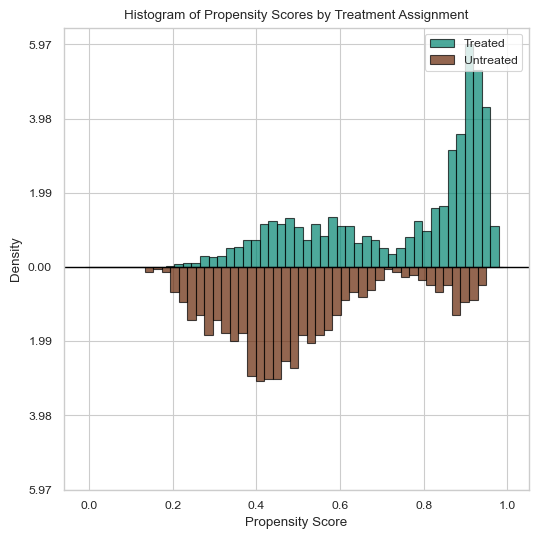

<Figure size 640x480 with 0 Axes>

In [39]:
sns.set_theme(style="whitegrid", context="paper")

# Create the directory if it doesn't exist
directory = 'results/figures_drug/ps_treatment/'
os.makedirs(directory, exist_ok=True)

# Separate propensity scores based on treatment assignment
treated_propensity = m_0[treatment == 1]
untreated_propensity = m_0[treatment == 0]

# Define bins for the histograms
bins = np.linspace(0, 1, 50)  # Adjust the number of bins to your data

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot histogram for treated above the horizontal line
hist_treated, bins_treated, _ = ax.hist(treated_propensity, bins=bins, alpha=0.7, density=True, color='#018571', edgecolor='black', label='Treated')

# Calculate histogram for untreated but don't plot yet
hist_untreated, bins_untreated = np.histogram(untreated_propensity, bins=bins, density=True)

# Invert the untreated histogram and plot it below the zero line
ax.bar(bins_untreated[:-1], -hist_untreated, width=np.diff(bins_untreated), edgecolor='black', alpha=0.7, color='#662506', label='Untreated')

# Add a horizontal line for separation
ax.axhline(y=0, color='black', linewidth=1)

# Manually set the y-axis ticks and labels to show positive values on both sides
ticks = np.linspace(-max(hist_untreated.max(), hist_treated.max()), max(hist_untreated.max(), hist_treated.max()), 7)
ax.set_yticks(ticks)
ax.set_yticklabels([f'{abs(tick):.2f}' for tick in ticks])

# Add labels and legend
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Density')
ax.set_title('Histogram of Propensity Scores by Treatment Assignment')
ax.legend(loc='upper right')

filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
plt.savefig(f'{directory}{filename}',bbox_inches='tight')
plt.show()
plt.clf()

In [ ]:
# Create the directory if it doesn't exist
directory = 'results/figures_drug/ps_treatment_2/'
os.makedirs(directory, exist_ok=True)

def plot_overlap_ratio(
    df: pd.DataFrame,
    ps_col: str,
    treatment_col: str,
    metric: str,
    clipping_threshold: float=1e-12,
    n_bins=50,
):
    valid_metrics = ['ratio', 'count']
    assert metric in valid_metrics, "Invalid metric"

    y_col = "ratio" if metric == "ratio" else "count"
    y_label = "Ratio" if metric == "ratio" else "Count"

    df_propensity = df.assign(
        m_hat = lambda d: d[ps_col].clip(clipping_threshold, 1.0 - clipping_threshold),
    )
    treatment_indicator = df[treatment_col] == 1

    bin_edges = np.linspace(df_propensity["m_hat"].min(), df_propensity["m_hat"].max(), n_bins + 1)

    bin_midpoints = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(n_bins)]
    bin_size = [(bin_edges[i+1] - bin_edges[i]) for i in range(n_bins)]

    count_treated = [np.nan] * n_bins
    neg_count_control = [np.nan] * n_bins

    ratio_treated = [np.nan] * n_bins
    neg_ratio_control = [np.nan] * n_bins

    for i, (bin_start, bin_end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        bin_obs = (df_propensity["m_hat"] >= bin_start) & (df_propensity["m_hat"] <= bin_end) if i == 0 else (df_propensity["m_hat"] > bin_start) & (df_propensity["m_hat"] <= bin_end)

        bin_treated = bin_obs & treatment_indicator
        bin_control = bin_obs & ~treatment_indicator

        bin_n_treated = bin_treated.sum()
        bin_n_control = bin_control.sum()
        bin_n_obs = bin_n_treated + bin_n_control

        count_treated[i] = bin_n_treated
        neg_count_control[i] = -1 * bin_n_control
        ratio_treated[i] = bin_n_treated / bin_n_obs
        neg_ratio_control[i] = -1 * bin_n_control / bin_n_obs

    df_plot = pd.DataFrame({
        "bin_midpoint": bin_midpoints * 2,
        "bin_size": bin_size * 2,
        "count": count_treated + neg_count_control,
        "ratio": ratio_treated + neg_ratio_control,
        "category": ["Treated"] * n_bins + ["Control"] * n_bins,
    })

    chart = (
        ggplot(df_plot, aes(x="bin_midpoint", y=y_col, fill="category")) +
        geom_col(aes(width="bin_size"), color="black") +
        labs(title="Overlap", x="Propensity Score", y=y_label) +
        scale_y_continuous(labels=lambda l: [abs(i) for i in l]) +
        scale_fill_manual(values={"Treated": "skyblue", "Control": "salmon"}) +
        geom_segment(aes(x=0, xend=1, y=0, yend=1), linetype="dashed", color="black", size=0.5) +
        geom_segment(aes(x=0, xend=1, y=-1, yend=0), linetype="dashed", color="black", size=0.5) +
        theme_light() + 
        theme(panel_grid_major=element_line(color="#DCDCDC"), 
              panel_grid_minor=element_line(color="#E6E6E6"), 
              plot_title=element_text(size=12, face="bold"))
    )

    return chart

def plot_subgroup_overlap_ratio(
    df: pd.DataFrame,
    df_subgroups: pd.DataFrame,
    ps_col: str,
    treatment_col: str,
    metric: str,
    clipping_threshold: float=1e-12,
    n_bins=50,
):
    kwargs = {
        "ps_col": ps_col,
        "treatment_col": treatment_col,
        "metric": metric,
        "clipping_threshold": clipping_threshold,
        "n_bins": n_bins,
    }
    n_obs = df.shape[0]
    for col in df_subgroups.columns:
        subgroup = df_subgroups[col]
        share_subgroup = round(sum(subgroup) / n_obs, 4)
        plot = plot_overlap_ratio(df=df[subgroup], **kwargs)
        plot += ggtitle(f"Overlap for Median Subgroup: {col}, (Top Share {share_subgroup * 100}%)")
        filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
                    f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}_{col}.pdf')          
        plot.save(f'{directory}{filename}',bbox_inches='tight')
        print(plot)

# Example usage
df = pd.DataFrame({
    "treatment": data_dict['treatment'],
    "outcome": data_dict['outcome'],
    "propensity_score": data_dict['propensity_score'],
    "x_2": data_dict['covariates']["x2"],
    "x_3": data_dict['covariates']["x3"]
})

# Create full sample column (all entries are True)
#df['Full Sample'] = True

# Calculate the median of column 'x_1'
median_x2 = np.median(df['x_2'])
median_x3 = np.median(df['x_3'])


# Create the df_subgroups_2 column (True if 'x' > median)
df['x2'] = df['x_2'] > median_x2
df['x3'] = df['x_3'] > median_x3

# Create a DataFrame for the subgroups
df_subgroups = df[['x2', 'x3']]

# Plot the results for the subgroups
plot_subgroup_overlap_ratio(
    df=df,
    df_subgroups=df_subgroups,
    ps_col='propensity_score',
    treatment_col='treatment',
    metric='ratio',
    clipping_threshold=1e-12,
    n_bins=50
)

<ggplot: (640 x 480)>
<ggplot: (640 x 480)>


In [41]:
# Create the directory if it doesn't exist
directory = 'results/figures_drug/ps_treatment_2/'
os.makedirs(directory, exist_ok=True)

plot_full_sample =  plot_overlap_ratio(
    df=df,
    ps_col= 'propensity_score',
    treatment_col= 'treatment',
    metric= 'ratio',
    clipping_threshold= 1e-12,
    n_bins=50)
plot_full_sample += ggtitle(f"Overlap for DGP 2 Drug")

filename = (f'n_obs_{n_obs:05d}_dim_x_{dim_x:03d}_learner_m_{0:03d}_learner_g_{0:03d}_clip_{clipping_threshold:.2f}_'
            f'R2d_{R2_d:.2f}_overlap_{overlap:.2f}_share_treated_{share_treated:.2f}.pdf')          
plot_full_sample.save(f'{directory}{filename}',bbox_inches='tight')